In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import re
import pandas as pd
from utils import get_mask, overlay_mask, image_grid_text
from PIL import Image
import glob
from natsort import natsorted
from pathlib import Path
import os
from tqdm.auto import tqdm
from multiprocessing import Pool
from functools import partial

In [10]:
def read_annotation(path):
    with open(path, 'r') as file:
        annot = file.read()

    annot = annot.replace('taskAnswers:"', '"taskAnswers":')  # Fix the key wrapping
    annot = annot.replace('\\"', '"')  # Unescape the quotes
    annot = annot.replace('"\\n', '"')  # Remove unnecessary line breaks within strings
    annot = annot.replace('\\n', '')  # Remove newlines from the entire string
    annot = annot.replace('"[', '[').replace(']"', ']')  # Convert the inner JSON array to a list
    annot = re.sub(r'}"]\s+}', '}] }', annot)
    annot = json.loads(annot)["taskAnswers"][0]

    return annot

NUM_IMAGES_HIT = 10
root = "./annotation_all/raw_tan"
paths = natsorted(list(glob.glob(os.path.join(root, "*.json"))))

dataset_path = "dataset750_candidate_reformat.csv"
dataset_df = pd.read_csv(dataset_path)
image_paths = dataset_df["img_path"].to_list()

outdir = "./annotation_all"
def process_annot(path):
    annot = read_annotation(path)
    page_id = int(str(Path(path).stem).split("_")[-1])
    for i in range(NUM_IMAGES_HIT):
        image_id = page_id * NUM_IMAGES_HIT + i
        image = Image.open(image_paths[image_id])
        mask = get_mask(annot[f"annotatedResult{i+1}"]["labeledImage"]["pngImageData"])
        output = overlay_mask(image, mask, color=(0, 255, 0, 0))

        save_path = os.path.join(outdir, f"mask_{Path(root).stem}", f"{image_id}.png")
        os.makedirs(Path(save_path).parent, exist_ok=True)
        mask.save(save_path)
        
        save_path = os.path.join(outdir, f"overlay_{Path(root).stem}", f"{image_id}.png")
        os.makedirs(Path(save_path).parent, exist_ok=True)
        output.save(save_path)

process_func = partial(process_annot)
with Pool(16) as p:
    list(tqdm(p.imap(process_func, paths), total=len(paths)))

  0%|          | 0/75 [00:00<?, ?it/s]

# average

['annotation_all/label_moke/mask/2.png', 'annotation_all/label_som/mask/2.png', 'annotation_all/label_tan/mask/2.png', 'annotation_all/label_tree/mask/2.png']


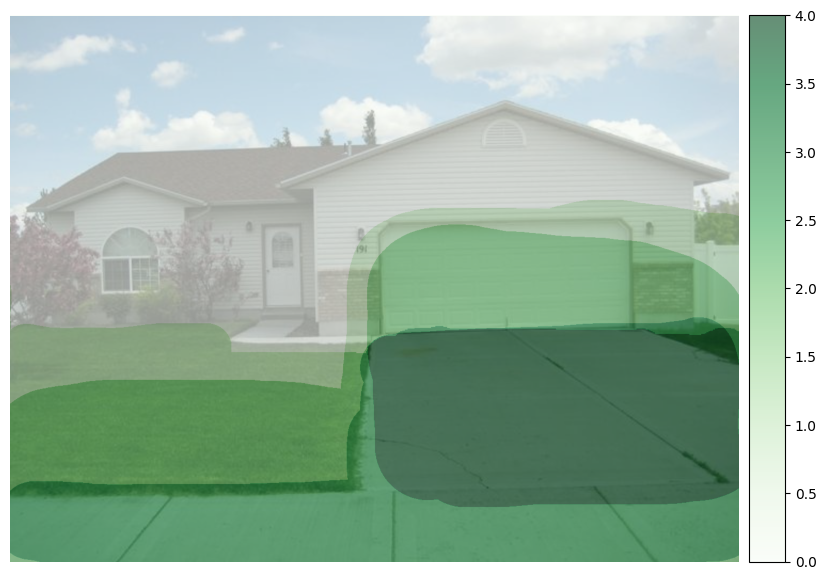

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

MIN_ANNOTATOR = 3

def combine_mask(paths):
    if len(paths) < MIN_ANNOTATOR: return None

    masks = [np.array(Image.open(path)) for path in paths]
    masks = [(mask > 0).astype(np.uint8) for mask in masks]
    result = np.stack(masks).sum(axis=0)
    
    return result

image_id = 2
root = "annotation_all"
paths = natsorted(list(glob.glob(os.path.join(root, f"label_*/mask/{image_id}.png"))))

print(paths)

# [
#     f"annotation_all/label_som/mask/{image_id}.png",
#     f"annotation_all/label_tan/mask/{image_id}.png",
#     f"annotation_all/label_tree/mask/{image_id}.png",
#     f"annotation_all/label_moke/mask/{image_id}.png",
#     # "annotation_all/label_tan/mask/0.png"
# ]
result = combine_mask(paths)

# mask1 = Image.open("annotation_all/label_som/mask/0.png")
# mask2 = Image.open("annotation_all/label_tan/mask/0.png")

# mask1 = np.array(mask1)
# mask1 = (mask1 > 0).astype(np.uint8)

# mask2 = np.array(mask2)
# mask2 = (mask2 > 0).astype(np.uint8)

# result = mask1 + mask2
# np.unique(result)

# plt.imshow(result, cmap='viridis')
dataset_df = pd.read_csv("dataset750_candidate_reformat.csv")
image_paths = dataset_df["img_path"].to_list()
bg_image = np.array(Image.open(image_paths[image_id]))

fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(bg_image, extent=[0, result.shape[1], result.shape[0], 0])
im = ax.imshow(result, cmap='Greens', alpha=0.6)
# im = ax.imshow(result >= 2, cmap='Greens', alpha=0.6)
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im, ax=ax, cax=cax)
# plt.imshow(result >= 2, cmap='viridis')
# plt.colorbar(orientation='horizontal')

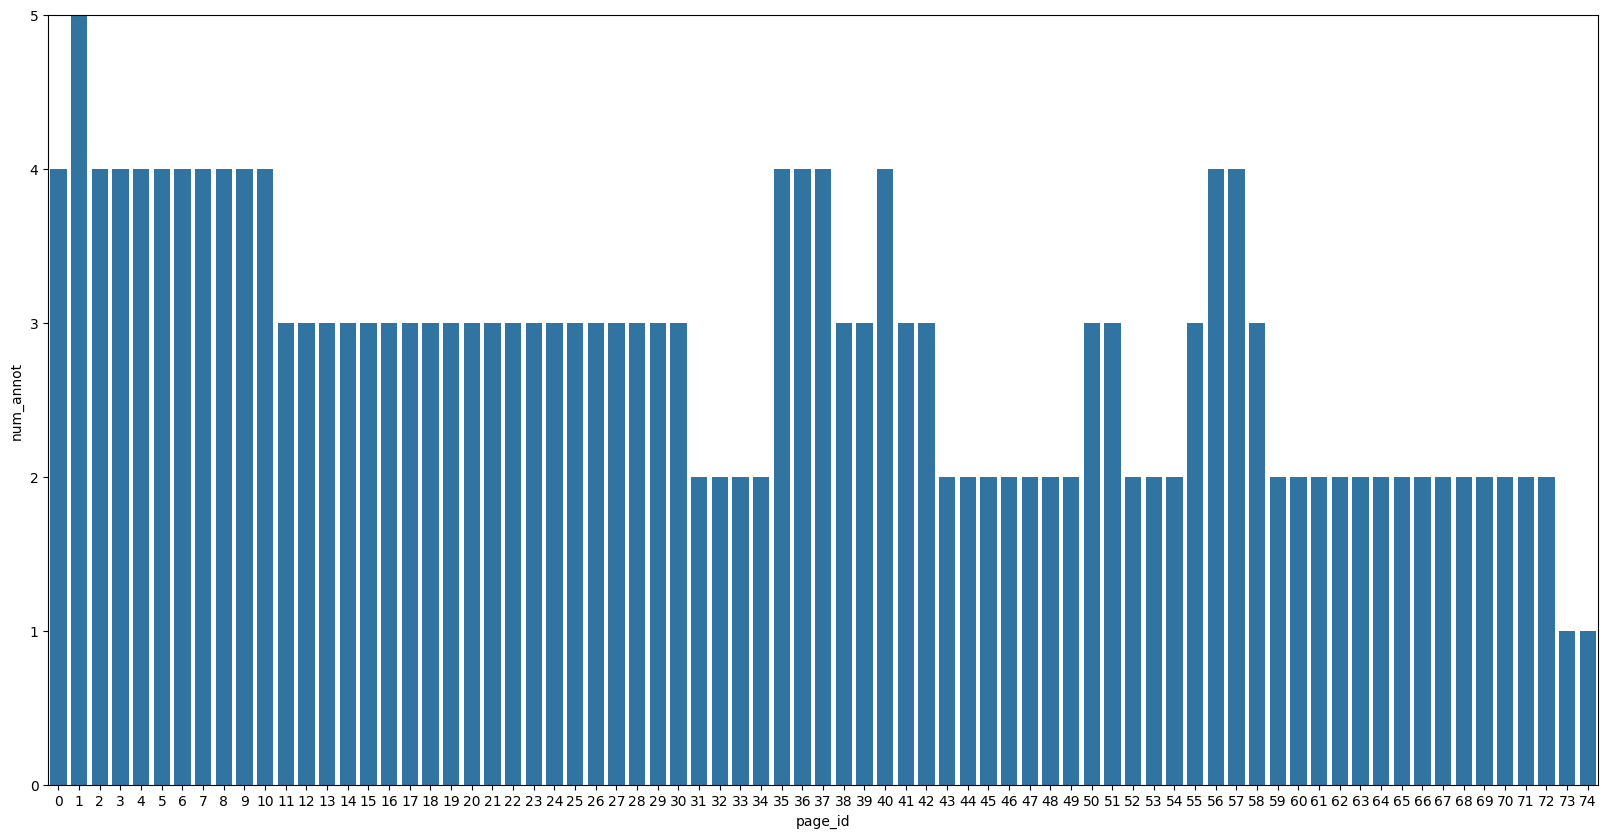

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from natsort import natsorted

dataset_df = pd.read_csv("dataset750_candidate_reformat.csv")
image_paths = dataset_df["img_path"].to_list()
image_ids = list(range(len(image_paths)))
root = "annotation_all"

df = []
for page_id in range(75):
    paths = natsorted(list(glob.glob(os.path.join(root, f"raw_*/annotation_{page_id}.json"))))
    df.append({
        "page_id": page_id,
        "num_annot": len(paths),
    })
df = pd.DataFrame(df)

import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(df, x="page_id", y="num_annot", ax=ax)
ax.set_ybound(0, 5)

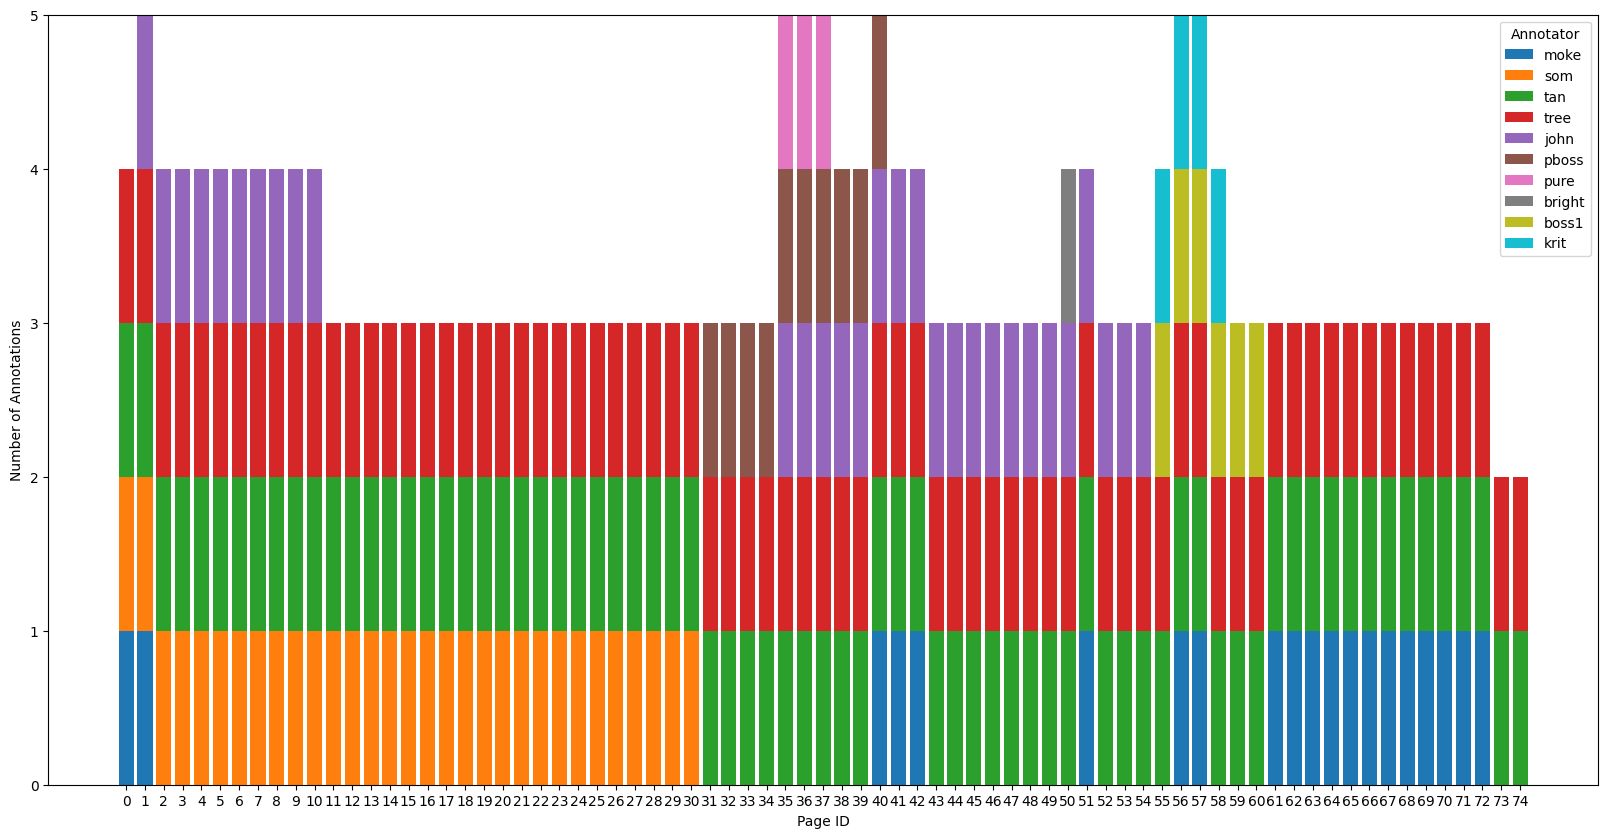

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from natsort import natsorted
import seaborn as sns

# Load dataset
dataset_df = pd.read_csv("dataset750_candidate_reformat.csv")
image_paths = dataset_df["img_path"].to_list()
image_ids = list(range(len(image_paths)))
root = "annotation_all"

# Initialize a DataFrame to hold the counts per directory for each page_id
df = []
for page_id in range(75):
    paths = natsorted(list(glob.glob(os.path.join(root, f"raw_*/annotation_{page_id}.json"))))
    
    # Dictionary to store counts per directory
    dir_count = {}
    for path in paths:
        # Extract directory name (e.g., "raw_one", "raw_two")
        dir_name = str(os.path.basename(os.path.dirname(path))).split("_")[-1]
        if dir_name in dir_count:
            dir_count[dir_name] += 1
        else:
            dir_count[dir_name] = 1
    
    # Create an entry for each page_id with directory counts
    df.append({
        "page_id": page_id,
        **dir_count
    })

# Convert list to DataFrame
df = pd.DataFrame(df).fillna(0)  # Fill NaNs with 0 for directories without files

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))

# Stacked bar plot
bottom = None
colors = sns.color_palette("tab10", len(df.columns) - 1)  # Unique color per directory

for i, dir_name in enumerate(df.columns[1:]):  # Skip the 'page_id' column
    ax.bar(df["page_id"], df[dir_name], bottom=bottom, color=colors[i], label=dir_name)
    if bottom is None:
        bottom = df[dir_name]
    else:
        bottom += df[dir_name]

ax.set_xticks(range(75))

# Set bounds and labels
ax.set_ybound(0, 5)
ax.set_xlabel("Page ID")
ax.set_ylabel("Number of Annotations")
ax.legend(title="Annotator")

plt.show()
